## 주안점
#### Quantization 전/후 model size & inference time 비교

- [참고] https://medium.com/@sanjanasrinivas73/post-training-static-quantization-pytorch-37dd187ba105

#### Quantized layer-wise histogram

- [참고] https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html?highlight=transformer

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 데이터 및 모델 준비
먼저 프루닝을 수행하기 위한 간단한 모델을 생성하고 훈련시켜 봅시다.

모델은 ResNet18, 데이터는 Mnist를 사용하겠습니다.

In [ ]:
train_loader = DataLoader(torchvision.datasets.MNIST('../data', train=True, download=True,
                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                    ])),
               batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

test_loader = DataLoader(torchvision.datasets.MNIST('../data', train=False, 
                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                    ])),
              batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


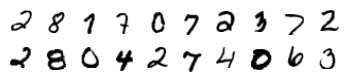

In [ ]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding
    
    Args:
        in_planes: number of channels in input image
        out_planes: number of channels produced by convolution
        stride: stride of the convolution. Default: 1
        groups: Number of blocked connections from input channels to output channels. Default: 1
        dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        
    Returns:
        Convoluted layer of kernel size=3, with specified out_planes
    
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution
    
    Args:
        in_planes: number of channels in input image
        out_planes: number of channels produced by convolution
        stride: stride of the convolution. Default: 1
        
    Returns:
        Convoluted layer of kernel size=1, with specified out_planes
        
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, quantize=False):
        super(BasicBlock, self).__init__()
        self.quantize = quantize
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        # FloatFunction()
        self.skip_add = nn.quantized.FloatFunctional()
        

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Notice the addition operation in both scenarios
        if self.quantize:
            out = self.skip_add.add(out, identity)
        else:
            out += identity

        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block=BasicBlock, layers=[2, 2, 2, 2], num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, mnist=False, quantize=False):
        super(ResNet, self).__init__()
        self.quantize = quantize
        if mnist:
            num_channels = 1
        else:
            num_channels = 3
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace 
            # the 2x2 stride with a dilated convolution instead.
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(num_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, quantize=self.quantize))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, quantize=self.quantize))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # Input are quantized
        if self.quantize:
            x = self.quant(x)
    
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        # Outputs are dequantized
        if self.quantize:
            x = self.dequant(x)
        
        return x

    def forward(self, x):
         # See note [TorchScript super()]
        return self._forward_impl(x)

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    """ Train the model with given dataset
    
    Args:
        args: args like log interval
        model: ResNet model to train
        device: CPU/GPU
        train_loader: dataset iterator
        optimizer: optimizer to update weights
        epoch: number of epochs to train for
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(F.log_softmax(output, dim=-1), target)
        loss.backward()
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
batch_size = 64
epochs = 5
lr = 0.01
momentum = 0.5
seed = 1
log_interval = 500
save_model = True
no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet(num_classes=10, mnist=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
args = {}
args["log_interval"] = log_interval
for epoch in range(1, epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)

if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.709100
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.027486
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.101788
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.038872
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.051835
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.020171
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004436
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.009814
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.038630
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.005278


# 모델 테스트
학습된 모델을 테스트 해보겠습니다.

In [ ]:
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
  
print_size_of_model(model)

def test(model, device, test_loader):
    model.to(device)
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            st = time.time()
            output = model(data)
            et = time.time()
            test_loss += F.nll_loss(F.log_softmax(output, dim=-1), target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

Size of the model(MB): 44.78267


In [ ]:
device = 'cpu'
model = ResNet(num_classes=10, mnist=True)
loaded_dict_enc = torch.load('mnist_cnn.pt', map_location=device)
model.load_state_dict(loaded_dict_enc)
test(model=model, device=device, test_loader=test_loader)

========================================= PERFORMANCE =============================================
Size of the model(MB): 44.780931

Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99%)

Elapsed time = 45.8539 milliseconds


# Dynamic Quantization
Dynamic Quantization은 모델의 weight를 quantizing 하는 방법입니다.
또한 매 순간 레이어의 출력 activation을 더 적은 비트(int8)로 변환을 하게 됩니다(따라서 Dynamic이란 이름이 붙었습니다).

하지만 여전히 계산의 결과물은 float32의 형태로 메모리에 read & write 됩니다. 즉 int8 연산 수행(이 때 해당 결과는 float32의 형태로 나오는 것을 허용) -> 결과물을 int8로 변환 -> 다시 연산 수행의 과정을 거치게 됩니다.

학습된 모델의 Linear 레이어를 quantize_dynamic를 활용하여 quantizing 해보겠습니다.
(참고: 현재 pytorch의 quantize_dynamic 함수는 nn.Linear,  nn.LSTM에 대해서만 지원을 하고 있습니다.)

In [ ]:
quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [ ]:
device = 'cpu'
test(model=quantized_model, device=device, test_loader=test_loader)

========================================= PERFORMANCE =============================================
Size of the model(MB): 44.766353

Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99%)

Elapsed time = 44.3783 milliseconds


# Static Quantization
Static Quantization은 Dynamic Quantization에서 한발 더 나아가, 모든 연산의 결과도 int8의 형태로만 저장하는 quantization 방식입니다. 일반적으로 모델의 학습이 종료된 이후, quantization 효율을 극대화하기 위해 Static Quantization을 사용하게 됩니다.

위에서 학습한 모델을 해당 방식으로 quantizing 해보도록 하겠습니다.

In [ ]:
def static_quantize(model, device, test_loader, quantize=False, fbgemm=False):
    model.to(device)
    model.eval()

    modules_to_fuse = [['conv1', 'bn1'],
            ['layer1.0.conv1', 'layer1.0.bn1'],
            ['layer1.0.conv2', 'layer1.0.bn2'],
            ['layer1.1.conv1', 'layer1.1.bn1'],
            ['layer1.1.conv2', 'layer1.1.bn2'],
            ['layer2.0.conv1', 'layer2.0.bn1'],
            ['layer2.0.conv2', 'layer2.0.bn2'],
            ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
            ['layer2.1.conv1', 'layer2.1.bn1'],
            ['layer2.1.conv2', 'layer2.1.bn2'],
            ['layer3.0.conv1', 'layer3.0.bn1'],
            ['layer3.0.conv2', 'layer3.0.bn2'],
            ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
            ['layer3.1.conv1', 'layer3.1.bn1'],
            ['layer3.1.conv2', 'layer3.1.bn2'],
            ['layer4.0.conv1', 'layer4.0.bn1'],
            ['layer4.0.conv2', 'layer4.0.bn2'],
            ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
            ['layer4.1.conv1', 'layer4.1.bn1'],
            ['layer4.1.conv2', 'layer4.1.bn2']]
    model = torch.quantization.fuse_modules(model, modules_to_fuse)
    if fbgemm:
        model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    else:
        model.qconfig = torch.quantization.default_qconfig
    torch.quantization.prepare(model, inplace=True)
    model.eval()
    with torch.no_grad():
        for data, target in train_loader:
            model(data)
    torch.quantization.convert(model, inplace=True)

    return model

In [ ]:
# def test(model, device, test_loader, quantize=False, fbgemm=False):
#     model.to(device)
#     model.eval()
    
#     # Testing with qauntization if quantize=True
#     if quantize:
#         modules_to_fuse = [['conv1', 'bn1'],
#                    ['layer1.0.conv1', 'layer1.0.bn1'],
#                    ['layer1.0.conv2', 'layer1.0.bn2'],
#                    ['layer1.1.conv1', 'layer1.1.bn1'],
#                    ['layer1.1.conv2', 'layer1.1.bn2'],
#                    ['layer2.0.conv1', 'layer2.0.bn1'],
#                    ['layer2.0.conv2', 'layer2.0.bn2'],
#                    ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
#                    ['layer2.1.conv1', 'layer2.1.bn1'],
#                    ['layer2.1.conv2', 'layer2.1.bn2'],
#                    ['layer3.0.conv1', 'layer3.0.bn1'],
#                    ['layer3.0.conv2', 'layer3.0.bn2'],
#                    ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
#                    ['layer3.1.conv1', 'layer3.1.bn1'],
#                    ['layer3.1.conv2', 'layer3.1.bn2'],
#                    ['layer4.0.conv1', 'layer4.0.bn1'],
#                    ['layer4.0.conv2', 'layer4.0.bn2'],
#                    ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
#                    ['layer4.1.conv1', 'layer4.1.bn1'],
#                    ['layer4.1.conv2', 'layer4.1.bn2']]
#         model = torch.quantization.fuse_modules(model, modules_to_fuse)
#         if fbgemm:
#             model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
#         else:
#             model.qconfig = torch.quantization.default_qconfig
#         torch.quantization.prepare(model, inplace=True)
#         model.eval()
#         with torch.no_grad():
#             for data, target in train_loader:
#                 model(data)
#         torch.quantization.convert(model, inplace=True)

#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             st = time.time()
#             output = model(data)
#             et = time.time()
#             test_loss += F.nll_loss(F.log_softmax(output, dim=-1), target, reduction='sum').item() # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
    
#     print("========================================= PERFORMANCE =============================================")
#     print_size_of_model(model)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
#     print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
#     print("====================================================================================================")
#     return model

In [ ]:
device = 'cpu'
model = ResNet(num_classes=10, mnist=True, quantize=True)
loaded_dict_enc = torch.load('mnist_cnn.pt', map_location=device)
model.load_state_dict(loaded_dict_enc)
quantized_model = static_quantize(model=model, device=device, test_loader=test_loader, quantize=True, fbgemm=False)

test(model=quantized_model, device=device, test_loader=test_loader)

/usr/local/lib/python3.6/dist-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


========================================= PERFORMANCE =============================================
Size of the model(MB): 11.21975

Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99%)

Elapsed time = 15.2705 milliseconds


# qauntized layer histogram

원 모델과 quantized된 모델의 값이 차이가 나는 부분을 히스토그램으로 그려봅시다.

In [ ]:
import torch.quantization._numeric_suite as ns
from torch.quantization import (
    default_eval_fn,
    default_qconfig,
    quantize,
)

In [ ]:
wt_compare_dict = ns.compare_weights(model.state_dict(), quantized_model.state_dict())

print('keys of wt_compare_dict:')
print(wt_compare_dict.keys())

print("\nkeys of wt_compare_dict entry for conv1's weight:")
print(wt_compare_dict['conv1.weight'].keys())
print(wt_compare_dict['conv1.weight']['float'].shape)
print(wt_compare_dict['conv1.weight']['quantized'].shape)

keys of wt_compare_dict:
dict_keys(['conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight', 'layer1.1.conv1.weight', 'layer1.1.conv2.weight', 'layer2.0.conv1.weight', 'layer2.0.conv2.weight', 'layer2.0.downsample.0.weight', 'layer2.1.conv1.weight', 'layer2.1.conv2.weight', 'layer3.0.conv1.weight', 'layer3.0.conv2.weight', 'layer3.0.downsample.0.weight', 'layer3.1.conv1.weight', 'layer3.1.conv2.weight', 'layer4.0.conv1.weight', 'layer4.0.conv2.weight', 'layer4.0.downsample.0.weight', 'layer4.1.conv1.weight', 'layer4.1.conv2.weight', 'fc._packed_params._packed_params'])

keys of wt_compare_dict entry for conv1's weight:
dict_keys(['float', 'quantized'])
torch.Size([64, 1, 7, 7])
torch.Size([64, 1, 7, 7])


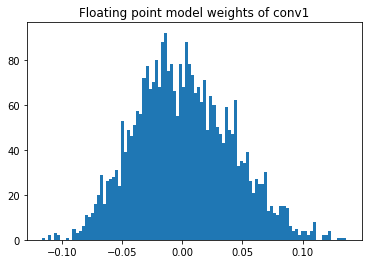

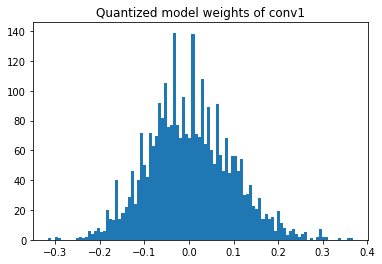

In [ ]:
f = wt_compare_dict['conv1.weight']['float'].flatten()
plt.hist(f, bins = 100)
plt.title("Floating point model weights of conv1")
plt.show()

q = wt_compare_dict['conv1.weight']['quantized'].flatten().dequantize()
plt.hist(q, bins = 100)
plt.title("Quantized model weights of conv1")
plt.show()

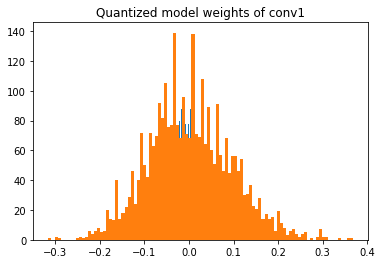

In [ ]:
f = wt_compare_dict['conv1.weight']['float'].flatten()
plt.hist(f, bins = 100)
plt.title("Floating point model weights of conv1")

q = wt_compare_dict['conv1.weight']['quantized'].flatten().dequantize()
plt.hist(q, bins = 100)
plt.title("Quantized model weights of conv1")
plt.show()